# Image Similarity System with Deep Autoencoders

## Installing and Loading Packages

In [15]:
# Python Version
from platform import python_version
print('Python Version: ', python_version())

Python Version:  3.11.5


In [16]:
#!pip install -q -U watermark

In [17]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [18]:
#!pip install -q -U torch

In [19]:
#!pip install -q -U torchvision

In [20]:
#!pip install -q -U pytorch-lightning

In [21]:
# Imports
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Packages versions
%reload_ext watermark
%watermark -a "Cezar Mendes" --iversions

Author: Cezar Mendes

seaborn          : 0.13.0
matplotlib       : 3.8.2
torchvision      : 0.16.1
json             : 2.0.9
pytorch_lightning: 2.1.2
torch            : 2.1.1
numpy            : 1.26.2



## Data Loading and Processing

In [23]:
# Seed
pl.seed_everything(42)

Seed set to 42


42

In [24]:
# Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [25]:
# Dataset folder
DATASET_PATH = "dataset"

In [26]:
# Model folder
CHECKPOINT_PATH = "models"

In [27]:
# Applying Transformations to each image
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [28]:
# Loading train dataset
train_images = CIFAR10(root = DATASET_PATH,
                       train = True,
                       transform = transform,
                       download = True)

Files already downloaded and verified


In [29]:
pl.seed_everything(42)

Seed set to 42


42

In [30]:
# Splitting train dataset in train and validation
train_dataset, valid_dataset = torch.utils.data.random_split(train_images, [45000, 5000])

In [31]:
# Loading test dataset
test_dataset = CIFAR10(root = DATASET_PATH,
                       train = False,
                       transform = transform,
                       download = True)

Files already downloaded and verified


> Defining dataloaders.

In [32]:
train_loader = data.DataLoader(train_dataset,
                               batch_size = 256,
                               shuffle = True,
                               drop_last = True,
                               pin_memory= True,
                               num_workers= 4)

In [33]:
valid_loader = data.DataLoader(valid_dataset,
                               batch_size = 256,
                               shuffle = False,
                               drop_last = False,
                               num_workers= 4)

In [34]:
test_loader = data.DataLoader(test_dataset,
                               batch_size = 256,
                               shuffle = False,
                               drop_last = False,
                               num_workers= 4)

In [35]:
# Function to get an image
def get_train_images(num):
  return torch.stack([train_images[i][0] for i in range(num)], dim = 0)

## Building Model

### Encoder

In [36]:
# Class Encoder
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 # GELU = Cumulative Distribution Function for Gaussian Distribution
                 act_fn : object = nn.GELU):

        super().__init__()

        c_hid = base_channel_size

        self.net = nn.Sequential(

            # https://www.cs.toronto.edu/~kriz/cifar.html
            # 32x32 => 16x16
            nn.Conv2d(num_input_channels,
                      c_hid,
                      kernel_size = 3,
                      padding = 1,
                      stride = 2),

            act_fn(),

            nn.Conv2d(c_hid,
                      c_hid,
                      kernel_size = 3,
                      padding = 1),

            act_fn(),

            # 16x16 => 8x8
            nn.Conv2d(c_hid,
                      2*c_hid,
                      kernel_size = 3,
                      padding = 1,
                      stride = 2),

            act_fn(),

            nn.Conv2d(2*c_hid,
                      2*c_hid,
                      kernel_size = 3,
                      padding = 1),

            act_fn(),

            # 8x8 => 4x4
            nn.Conv2d(2*c_hid,
                      2*c_hid,
                      kernel_size = 3,
                      padding = 1,
                      stride = 2),

            act_fn(),

            nn.Flatten(),

            nn.Linear(2*16*c_hid,
                      latent_dim)
        )

    def forward(self, x):
        return self.net(x)



- Please note that I have chosen not to apply batch normalization in this instance. The reasoning behind this decision is that I aim for the encoding of each image to remain independent from all others. Applying batch normalization could potentially introduce correlations into the encoding or decoding processes—something I wish to avoid.

### Decoder

In [37]:
# Class Decoder
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):

        super().__init__()

        c_hid = base_channel_size

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )

        self.net = nn.Sequential(

            # 4x4 => 8x8
            nn.ConvTranspose2d(2*c_hid,
                               2*c_hid,
                               kernel_size = 3,
                               output_padding = 1,
                               padding = 1,
                               stride = 2),

            act_fn(),

            nn.Conv2d(2*c_hid,
                      2*c_hid,
                      kernel_size = 3,
                      padding = 1),

            act_fn(),

            # 8x8 => 16x16
            nn.ConvTranspose2d(2*c_hid,
                               c_hid,
                               kernel_size = 3,
                               output_padding = 1,
                               padding = 1,
                               stride = 2),

            act_fn(),

            nn.Conv2d(c_hid, c_hid, kernel_size = 3, padding = 1),

            act_fn(),

            # 16x16 => 32x32
            nn.ConvTranspose2d(c_hid,
                               num_input_channels,
                               kernel_size = 3,
                               output_padding = 1,
                               padding = 1,
                               stride = 2),

            # Input images are scaled between -1 and 1, so the output must also be limited
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## Building Modules with Lightning - Deep Autoencoder


In [38]:
# DeepAutoencoder
class DeepAutoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):

        super().__init__()

        # Save Hyperparameters
        self.save_hyperparameters()

        # Creating Encoder and Decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

        # Example of input matrix required to visualize the network graph
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction = "none")
        loss = loss.sum(dim=[1,2,3]).mean(dim = [0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode = 'min',
                                                         factor = 0.2,
                                                         patience = 20,
                                                         min_lr = 5e-5)

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

- For the loss function, I used the mean squared error (MSE). The mean squared error causes the network to pay special attention to pixel values whose estimate is far away. Predicting 127 instead of 128 is not important when reconstructing, but confusing 0 with 128 is much worse. Unlike VAEs, I did not predict probability by pixel value, but used a distance measure. This saves a lot of parameters and simplifies training. To get better intuition per pixel, therefore the squared error summed over the batch size is reported (any other average/sum leads to the same result/parameters).

- However, MSE also has some considerable disadvantages. Typically MSE leads to blurry images where small high frequency noises/patterns are removed as they cause very low error.

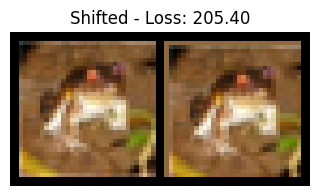

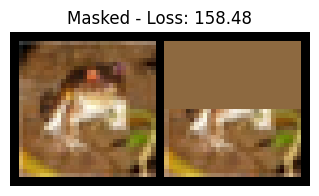

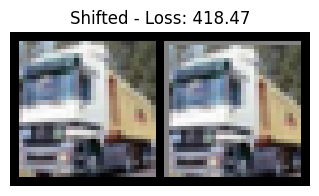

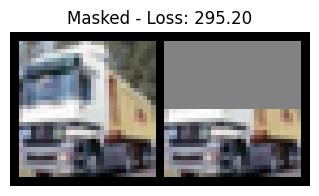

In [39]:
# Function to compare images
def compare_imgs(img1, img2, title_prefix=""):

    loss = F.mse_loss(img1, img2, reduction = "sum")

    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim = 0), nrow = 2, normalize = True, value_range = (-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):

    img, _ = train_images[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift the image by 1 pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts = SHIFT, dims = 1)
    img_shifted = torch.roll(img_shifted, shifts = SHIFT, dims = 2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Setting half of image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Model Training

In this part I implemented a callback object in PyTorch Lightning that will add reconstructions every $N$ epochs. Because during training I wanted to monitor the learning progress by seeing the reconstructions made by the model.

In [40]:
# Callback
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):

        if trainer.current_epoch % self.every_n_epochs == 0:

            # Reconstructs the image
            input_imgs = self.input_imgs.to(pl_module.device)

            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()

            # Plot e log
            imgs = torch.stack([input_imgs, reconst_imgs], dim = 1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow = 2, normalize = True, value_range = (-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step = trainer.global_step)

> Now the training function allows to train the model with different latent dimensionality and return the score in validation and testing.

In [41]:
# Training function
def train_model(latent_dim):

    trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
                         devices = 1,
                         max_epochs = 500,
                         callbacks = [ModelCheckpoint(save_weights_only = True),
                                      GenerateCallback(get_train_images(8), every_n_epochs = 10),
                                      LearningRateMonitor("epoch")])

    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")

    # Here If the model is already trained, it will be used. Otherwise, training will be carried out.
    if os.path.isfile(pretrained_filename):
        print("I found the trained model. Loading...")
        model = DeepAutoencoder.load_from_checkpoint(pretrained_filename)
    else:
        print("Starting training...")
        model = DeepAutoencoder(base_channel_size = 32, latent_dim = latent_dim)
        trainer.fit(model, train_loader, valid_loader)


    val_result = trainer.test(model, valid_loader, verbose = False)
    test_result = trainer.test(model, test_loader, verbose = False)

    result = {"test": test_result, "valid": val_result}

    return model, result

## Comparing Latent Dimensionality

- In this part I tried to find the best dimensionality for the latent representation $z$.

- The original input has $32\times 32\times 3 = 3072$ pixels. With this in mind, a reasonable choice for latent dimensionality might be between 64 and 384:

In [42]:
torch.set_float32_matmul_precision('high')

In [43]:
# Dict
model_dict = {}

In [ ]:
# Loop
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_model(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

> After training the models, we can plot the reconstruction loss over the latent dimensionality to get an intuition for how these two properties are correlated:

In [45]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["valid"][0]["test_loss"] for k in latent_dims]

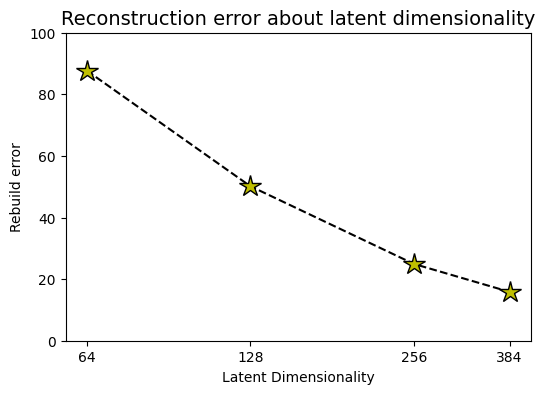

In [46]:
# Plot
fig = plt.figure(figsize = (6,4))
plt.plot(latent_dims, 
         val_scores, '--', 
         color = "#000", 
         marker = "*", 
         markeredgecolor = "#000", 
         markerfacecolor = "y", 
         markersize = 16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error about latent dimensionality", fontsize=14)
plt.xlabel("Latent Dimensionality")
plt.ylabel("Rebuild error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

- As initially expected, the reconstruction loss decreases with the increase in latent dimensionality.

- For model and configuration, the two properties appear to be exponentially correlated. 
- To understand what these differences in reconstruction error mean, you can view example reconstructions from the four models. 
- As seen before in the four CIFAR10 training images.Therefore, for larger models that may have overfit, it is interesting to use images from the validation set.

In [50]:
# Visualization function
def visualize_reconstructions(model, input_imgs):

    model.eval()
    
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    
    reconst_imgs = reconst_imgs.cpu()
    
    # Plot
    imgs = torch.stack([input_imgs, reconst_imgs], dim = 1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True, value_range= (-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Rebuilt from latent {model.hparams.latent_dim}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [52]:
input_imgs = get_train_images(4)

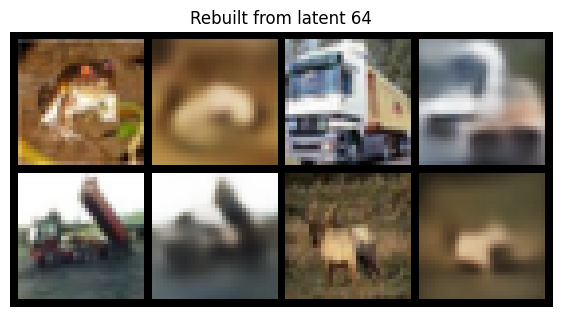

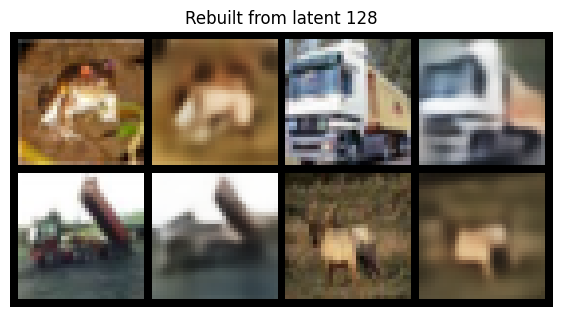

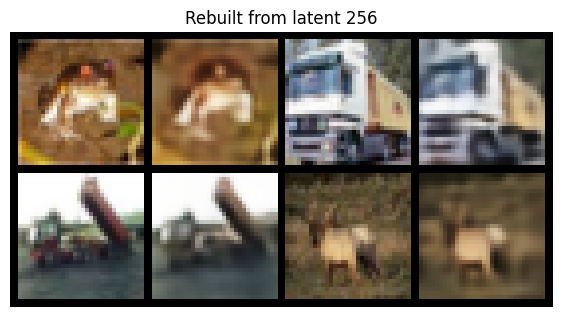

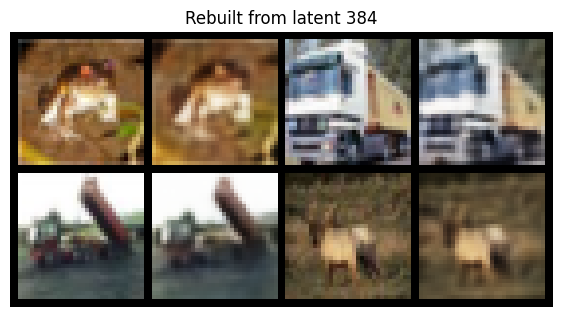

In [53]:
# Loop
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

### Results analysis - Different Latents

- Clearly, the smallest latent dimensionality can only save information about the shape and color of the object, but the reconstructed image is extremely blurry, and it is difficult to recognize the original object in the reconstruction.

- With 128 features, it is possible to recognize some shapes again, although the image remains blurry. Models with the highest two-dimensionalities reconstruct images very well. The difference between 256 and 384 is marginal at first glance, but can be noticed when comparing, for example, the backgrounds of the first image (the 384 features model the pattern more than 256).

## Exploring Model Limitations


**The first limitation for example is trying to reconstruct an image that is clearly outside the distribution of the dataset**. The decoder is expected to have learned some common patterns in the dataset and therefore may fail to reconstruct images that do not follow these patterns.

To solve:
**The first option is to try to reconstruct the noise**. In this way, two images are created whose pixels are randomly sampled from a uniform distribution over the pixel values and then the reconstruction of the model is visualized.

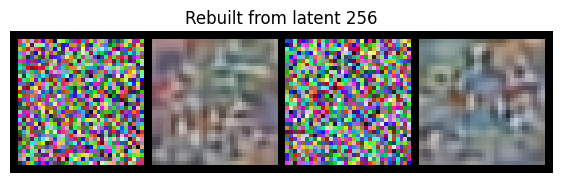

In [54]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

As known, the noise reconstruction is quite poor and appears to present some coarse patterns. Because the input does not follow the patterns of the CIFAR dataset, the model has trouble reconstructing it accurately.

You can also check how well the model can reconstruct other manually coded patterns:

In [55]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1,0] = 1

# Checkboard
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1

# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

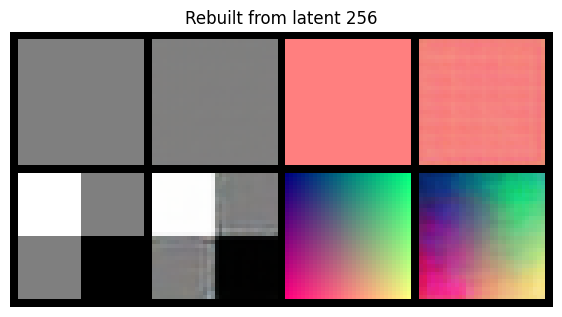

In [56]:
visualize_reconstructions(model_dict[256]["model"], plain_imgs)

### Analysis - Model Limitations
After observing the images above it is possible to identify that the simple and constant images are reconstructed relatively well, although the single color channel contains some noticeable noise. The hard edges of the Checkboard pattern are not as sharp as intended, as is the color progression, because these patterns never occur in CIFAR's real-world images.

In general, autoencoders tend to fail in reconstructing high-frequency noise (i.e., large sudden changes in a few pixels) due to the choice of MSE as the loss function.

In this case, small misalignments in the decoder can lead to large losses for the model to adjust to the expected value/average in these regions. For low-frequency noise, a misalignment of a few pixels does not result in a large difference in the original image. However, the larger the latent dimensionality becomes, the more of this high-frequency noise can be accurately reconstructed.

## Finding Visually Similar Images

- The main goal of this project is to develop an image-based search engine capable of retrieving visually similar images by using autoencoders to identify similarities between them.

- This can be done by representing all images as their latent dimensionality and finding the closest $K$ images in this domain. That is why different dimensionalities were used in the training.



In [61]:
model = model_dict[128]["model"]

In [62]:
def embed_imgs(model, data_loader):
    
     # Encode all images in data_laoder using the template and return images and encodings
     img_list, embed_list = [], []
     model.eval()
     for imgs, _ in tqdm(data_loader, desc = "Encoding images", leave = False):
        
         with torch.no_grad():
             z = model.encoder(imgs.to(model.device))
        
         img_list.append(imgs)
        
         embed_list.append(z)
    
     return (torch.cat(img_list, dim = 0), torch.cat(embed_list, dim = 0))

In [63]:
train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)

Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

In [64]:
# Similarity system function (euclidian distance)
def find_similar_images(query_img, query_z, key_embeds, K = 8):
     dist = torch.cdist(query_z[None,:], key_embeds[1], p = 2)
     dist = dist.squeeze(dim=0)
     dist, indices = torch.sort(dist)
     imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim = 0)
     grid = torchvision.utils.make_grid(imgs_to_display, nrow = K+1, normalize = True, value_range = (-1,1))
     grid = grid.permute(1, 2, 0)
     plt.figure(figsize = (12,3))
     plt.imshow(grid)
     plt.axis('off')
     plt.show()

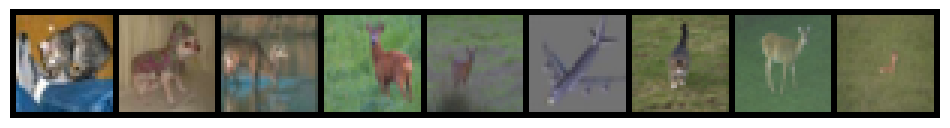

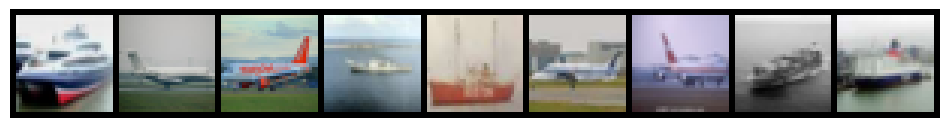

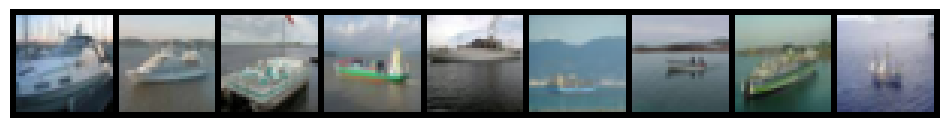

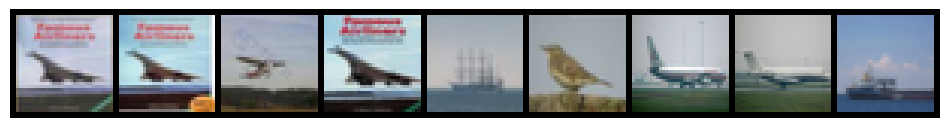

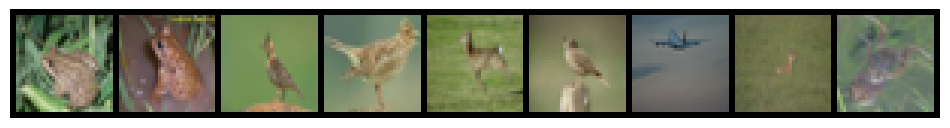

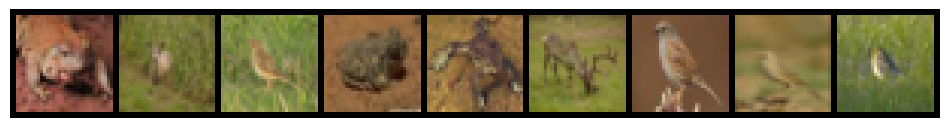

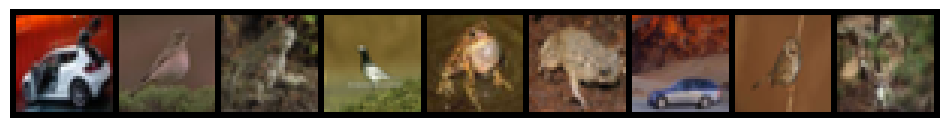

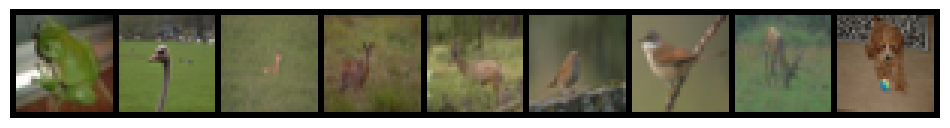

In [65]:
# Plot the closest images to the first N test images as an example
for i in range(8):
     find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds = train_img_embeds)

## Final Analysis - Similarity

- Based on the created autoencoder, it was possible to retrieve many images similar to the test input.

- In particular, in line 4, it is possible to identify that some test images may not be as different from the training set as expected (same poster, just different scale/color scale).

- It was also seen that although the model was not given any label, it can group different classes in different parts of the latent space (plane + ship, animals, etc.).

- However, it should be noted that the background still plays an important role in autoencoders, but not in classification.

- Finally, **"perfect"** clusters were not obtained and it is necessary to adjust these models for future classification.**